# Do logarithmic proximity measures outperform plain ones in graph clustering?

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import adjusted_rand_score

In [3]:
from pygraphs.graphs import StochasticBlockModel
from pygraphs.measure import *
from pygraphs.measure import kernels
from pygraphs.cluster import KKMeans, KWard
from pygraphs.scenario import ParallelByGraphs, plot_results
from pygraphs.scorer import rand_index
from pygraphs.util import load_or_calc_and_save

## 2. Logarithmic vs. plain measures
Let $G(N,(m)p_{in}, p_{out})$ be the model of generating random graphs on $N$ nodes divided into $m$ classes of the same size, with $p_{in}$ and pout being the probability of $(i, j) \in E(G)$ for $i$ and $j$ belonging to the same class and different classes, respectively, where $E(G)$ is the edge set of $G$.

The curves in Figures 1–3 present the adjusted Rand index (averaged over 200 random graphs) for clustering with Ward’s
method.

In [4]:
def plot_log_results(results):
    fig, ax = plt.subplots(2, 8, figsize=(15, 6))
    for idx_i, clustring_method in enumerate(tqdm([KKMeans, KWard])):
        ax[idx_i][0].set_ylabel(f'{clustring_method.name}, f1')
        for idx_j, (name1, name2, xlim, ylim) in enumerate([
            [(f'{clustring_method.name}_pWalk', 'pWalk'), (f'{clustring_method.name}_Walk', 'Walk'), (0, 1), (0, 1)],
            [(f'{clustring_method.name}_For', 'For'), (f'{clustring_method.name}_logFor', 'logFor'), (0, 1), (0, 1)],
            [(f'{clustring_method.name}_Comm', 'Comm'), (f'{clustring_method.name}_logComm', 'logComm'), (0, 0.83), (0, 1)],
            [(f'{clustring_method.name}_Heat', 'Heat'), (f'{clustring_method.name}_logHeat', 'logHeat'), (0, 0.83), (0, 1)],
            [(f'{clustring_method.name}_NHeat', 'NHeat'), (f'{clustring_method.name}_logNHeat', 'logNHeat'), (0, 0.83), (0, 1)],
            [(f'{clustring_method.name}_PPR', 'PPR'), (f'{clustring_method.name}_logPPR', 'logPPR'), (0, 1), (0, 1)],
            [(f'{clustring_method.name}_ModifPPR', 'ModifPPR'), (f'{clustring_method.name}_logModifPPR', 'logModifPPR'), (0, 1), (0, 1)],
            [(f'{clustring_method.name}_HeatPPR', 'HeatPPR'), (f'{clustring_method.name}_logHeatPPR', 'logHeatPPR'), (0, 1), (0, 1)]
        ]):
            try:
                toplot = [
                    (name1[1], *results[name1[0]]),
                    (name2[1], *results[name2[0]]),
                ]
                plot_results(ax[idx_i][idx_j], toplot, xlim, ylim)
            except:
                print('..')

In [5]:
def plot_log_results4(results):
    fig, ax = plt.subplots(2, 4, figsize=(7, 5), sharey=True)
    plt.subplots_adjust(hspace=.3, wspace=.2)
    for idx_j, (name1, name2, name3, name4, xlim, ylim) in enumerate([
        [(f'KernelKMeans_pWalk', 'pWalk'), (f'KernelKMeans_Walk', 'Walk'),
        (f'KernelWard_pWalk', 'pWalk'), (f'KernelWard_Walk', 'Walk'), (0, 1), (0, 1.05)],
        [(f'KernelKMeans_For', 'For'), (f'KernelKMeans_logFor', 'logFor'),
        (f'KernelWard_For', 'For'), (f'KernelWard_logFor', 'logFor'), (0, 1), (0, 1.05)],
        [(f'KernelKMeans_Comm', 'Comm'), (f'KernelKMeans_logComm', 'logComm'),
        (f'KernelWard_Comm', 'Comm'), (f'KernelWard_logComm', 'logComm'), (0, 0.6), (0, 1.05)],
        [(f'KernelKMeans_Heat', 'Heat'), (f'KernelKMeans_logHeat', 'logHeat'),
        (f'KernelWard_Heat', 'Heat'), (f'KernelWard_logHeat', 'logHeat'), (0, 0.83), (0, 1.05)],
        [(f'KernelKMeans_NHeat', 'NHeat'), (f'KernelKMeans_logNHeat', 'logNHeat'),
        (f'KernelWard_NHeat', 'NHeat'), (f'KernelWard_logNHeat', 'logNHeat'), (0, 1), (0, 1.05)],
        [(f'KernelKMeans_PPR', 'PPR'), (f'KernelKMeans_logPPR', 'logPPR'),
        (f'KernelWard_PPR', 'PPR'), (f'KernelWard_logPPR', 'logPPR'), (0, 1), (0, 1.05)],
        [(f'KernelKMeans_ModifPPR', 'ModifPPR'), (f'KernelKMeans_logModifPPR', 'logModifPPR'),
        (f'KernelWard_ModifPPR', 'ModifPPR'), (f'KernelWard_logModifPPR', 'logModifPPR'), (0, 1), (0, 1.05)],
        [(f'KernelKMeans_HeatPPR', 'HeatPPR'), (f'KernelKMeans_logHeatPPR', 'logHeatPPR'),
        (f'KernelWard_HeatPPR', 'HeatPPR'), (f'KernelWard_logHeatPPR', 'logHeatPPR'), (0, 1), (0, 1.05)]
    ]):
        try:
            toplot = [
                ("KernelKMeans, plain", *results[name1[0]]),
                ("KernelKMeans, log", *results[name2[0]]),
                ("KernelWard, plain", *results[name3[0]]),
                ("KernelWard, log", *results[name4[0]]),
            ]
            
            plot_results(ax[idx_j//4][idx_j%4], toplot, xlim, ylim, nolegend=True)
            ax[idx_j//4][idx_j%4].set_title(name1[1])
            if idx_j == 0 or idx_j == 4:
                ax[idx_j//4][idx_j%4].set_ylabel(f'ARI')
            if idx_j == 3:
                ax[idx_j//4][idx_j%4].legend(bbox_to_anchor=(1,1), loc="upper left")
        except:
            print('..')

### **Fig. 1** Logarithmic vs. plain measures for G(100,(2)0.2,0.05)

In [6]:
@load_or_calc_and_save('results/2_11_ari_with_PPR3.pkl')
def calc():
    results = defaultdict(list)
    graphs, info = StochasticBlockModel(100, 2, p_in=0.2, p_out=0.05).generate_graphs(200)
    classic_plot = ParallelByGraphs(adjusted_rand_score, np.linspace(0, 1, 101), progressbar=True)
    for clustring_method in tqdm([KKMeans, KWard]):
        for measure_class in tqdm([pWalk_H, Walk_H, For_H, logFor_H, Comm_H, logComm_H, Heat_H, logHeat_H, NHeat_H, logNHeat_H, PPR_H, logPPR_H, ModifPPR_H, logModifPPR_H, HeatPPR_H, logHeatPPR_H]):
            results[f"{clustring_method.name}_{measure_class.name}"] = \
                classic_plot.perform(clustring_method, measure_class, graphs, 2, n_jobs=10)
    return results

results = calc()

File exist! Skip calculations


In [7]:
results.keys()

dict_keys(['KernelKMeans_pWalk', 'KernelKMeans_Walk', 'KernelKMeans_For', 'KernelKMeans_logFor', 'KernelKMeans_Comm', 'KernelKMeans_logComm', 'KernelKMeans_Heat', 'KernelKMeans_logHeat', 'KernelKMeans_NHeat', 'KernelKMeans_logNHeat', 'KernelKMeans_PPR', 'KernelKMeans_logPPR', 'KernelKMeans_ModifPPR', 'KernelKMeans_logModifPPR', 'KernelKMeans_HeatPPR', 'KernelKMeans_logHeatPPR', 'KernelWard_pWalk', 'KernelWard_Walk', 'KernelWard_For', 'KernelWard_logFor', 'KernelWard_Comm', 'KernelWard_logComm', 'KernelWard_Heat', 'KernelWard_logHeat', 'KernelWard_NHeat', 'KernelWard_logNHeat', 'KernelWard_PPR', 'KernelWard_logPPR', 'KernelWard_ModifPPR', 'KernelWard_logModifPPR', 'KernelWard_HeatPPR', 'KernelWard_logHeatPPR'])

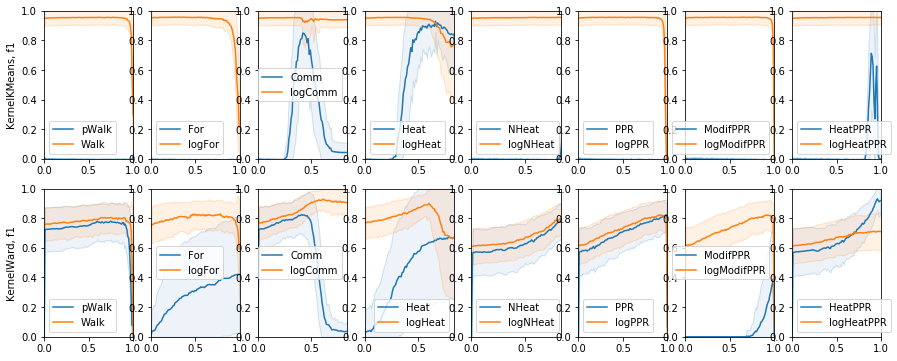

KeyboardInterrupt: 

In [8]:
plot_log_results(results)
# gcf().suptitle("Fig. 1 Logarithmic vs. plain measures for G(100,(2)0.2,0.05)");

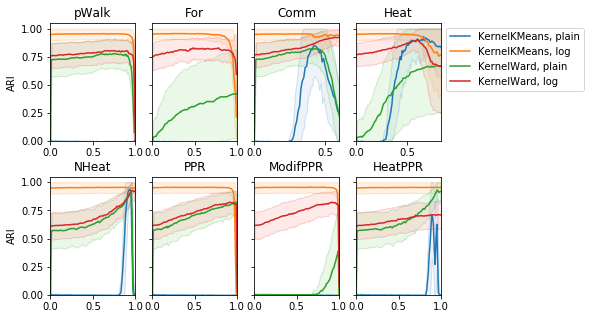

In [9]:
plot_log_results4(results)

### **Fig. 2** Logarithmic vs. plain measures for G(100,(3)0.3,0.1)

In [10]:
@load_or_calc_and_save('results/2_21_ari_with_PPR3.pkl')
def calc():
    results = defaultdict(list)
    graphs, info = StochasticBlockModel(102, 3, p_in=0.3, p_out=0.1).generate_graphs(200)
    classic_plot = ParallelByGraphs(adjusted_rand_score, np.linspace(0, 1, 101), progressbar=True)
    for clustring_method in tqdm([KKMeans, KWard]):
        for measure_class in tqdm([pWalk_H, Walk_H, For_H, logFor_H, Comm_H, logComm_H, Heat_H, logHeat_H, NHeat_H, logNHeat_H, PPR_H, logPPR_H, ModifPPR_H, logModifPPR_H, HeatPPR_H, logHeatPPR_H]):
            results[f"{clustring_method.name}_{measure_class.name}"] = \
                classic_plot.perform(clustring_method, measure_class, graphs, 2, n_jobs=10)
    return results

results = calc()

File exist! Skip calculations


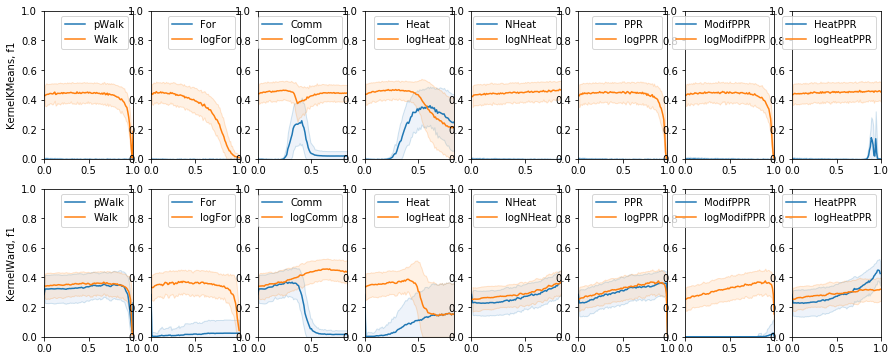

In [11]:
plot_log_results(results)
# gcf().suptitle('Fig. 2 Logarithmic vs. plain measures for G(100,(3)0.3,0.1)');

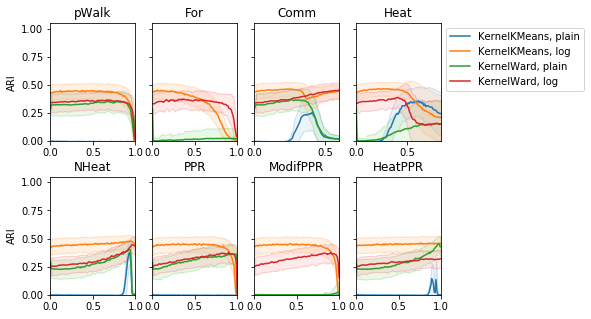

In [12]:
plot_log_results4(results)

### **Fig. 3** Logarithmic vs. plain measures for G(200,(2)0.3,0.1)

In [13]:
@load_or_calc_and_save('results/2_31_ari_with_PPR3.pkl')
def calc():
    results = defaultdict(list)
    graphs, info = StochasticBlockModel(200, 2, p_in=0.3, p_out=0.1).generate_graphs(200)
    classic_plot = ParallelByGraphs(adjusted_rand_score, np.linspace(0, 1, 101), progressbar=True)
    for clustring_method in tqdm([KKMeans, KWard]):
        for measure_class in tqdm([pWalk_H, Walk_H, For_H, logFor_H, Comm_H, logComm_H, Heat_H, logHeat_H, NHeat_H, logNHeat_H, PPR_H, logPPR_H, ModifPPR_H, logModifPPR_H, HeatPPR_H, logHeatPPR_H]):
            results[f"{clustring_method.name}_{measure_class.name}"] = \
                classic_plot.perform(clustring_method, measure_class, graphs, 2, n_jobs=10)
    return results

results = calc()

File exist! Skip calculations


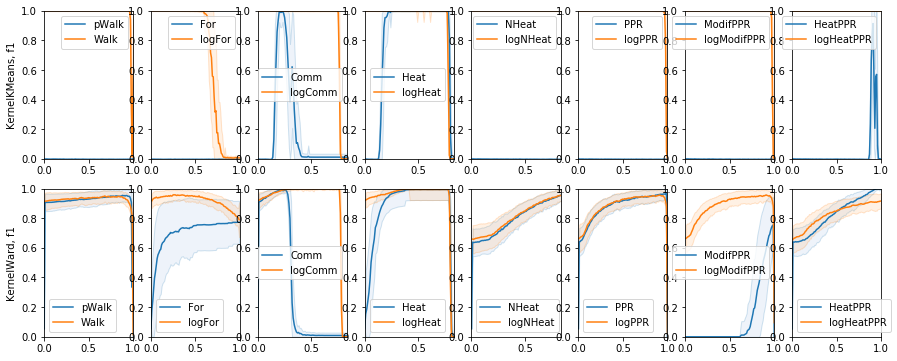

In [14]:
plot_log_results(results)
# gcf().suptitle('Fig. 3 Logarithmic vs. plain measures for G(200,(2)0.3,0.1)');

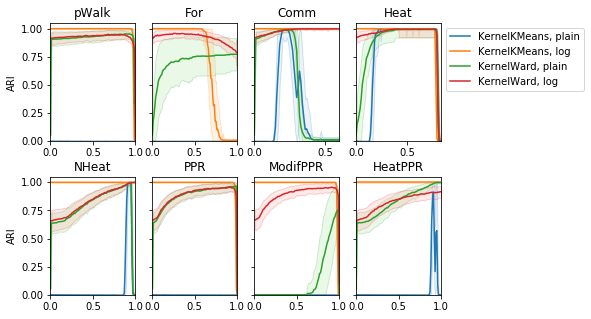

In [15]:
plot_log_results4(results)